(updating_priors)=
# Updating Priors

:::{post} January, 2017
:tags: priors
:category: intermediate, how-to
:author: [David Brochart](https://github.com/davidbrochart)
:::

In this notebook, we will show how, in principle, it is possible to update the priors as new data becomes available.

`````{admonition} Words of Caution
:class: warning
This example provides a very nice usage example for the {class}`~pymc.Interpolated` class, as we will see below. However, this might not be a good idea to do in practice, not only because KDEs are being used to compute pdf values for the posterior, but mostly because Interpolated distributions used as priors are **unidimensional** and **uncorrelated**.  So even if a perfect fit *marginally* they don't really incorporate all the information we have from the previous posterior into the model, especially when posterior variables are correlated. See a nice discussion about the subject in the blog post [Some dimensionality devils](https://oriolabrilpla.cat/en/blog/posts/2022/too-eager-reduction.html#univariate-priors) by [Oriol Abril](https://oriolabrilpla.cat/en/).
``````

In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from scipy import stats
from tqdm.notebook import trange

az.style.use("arviz-white")

%config InlineBackend.figure_format = "retina"

In [2]:
rng: np.random.Generator = np.random.default_rng(seed=42)

## Generating data

In [3]:
# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13
sigma_true = 2

# Size of dataset
size = 100

# Predictor variable
X1 = rng.normal(size=size)
X2 = rng.normal(size=size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + rng.normal(size=size, scale=sigma_true)

## Model specification

Our initial beliefs about the parameters are quite informative (sigma=1) and a bit off the true values.

In [4]:
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta0 = pm.Normal("beta0", mu=0, sigma=5)
    beta1 = pm.Normal("beta1", mu=0, sigma=5)

    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # draw 2_000 posterior samples
    trace = pm.sample(
        tune=1_500, draws=2_000, target_accept=0.9, progressbar=False, random_seed=rng
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.


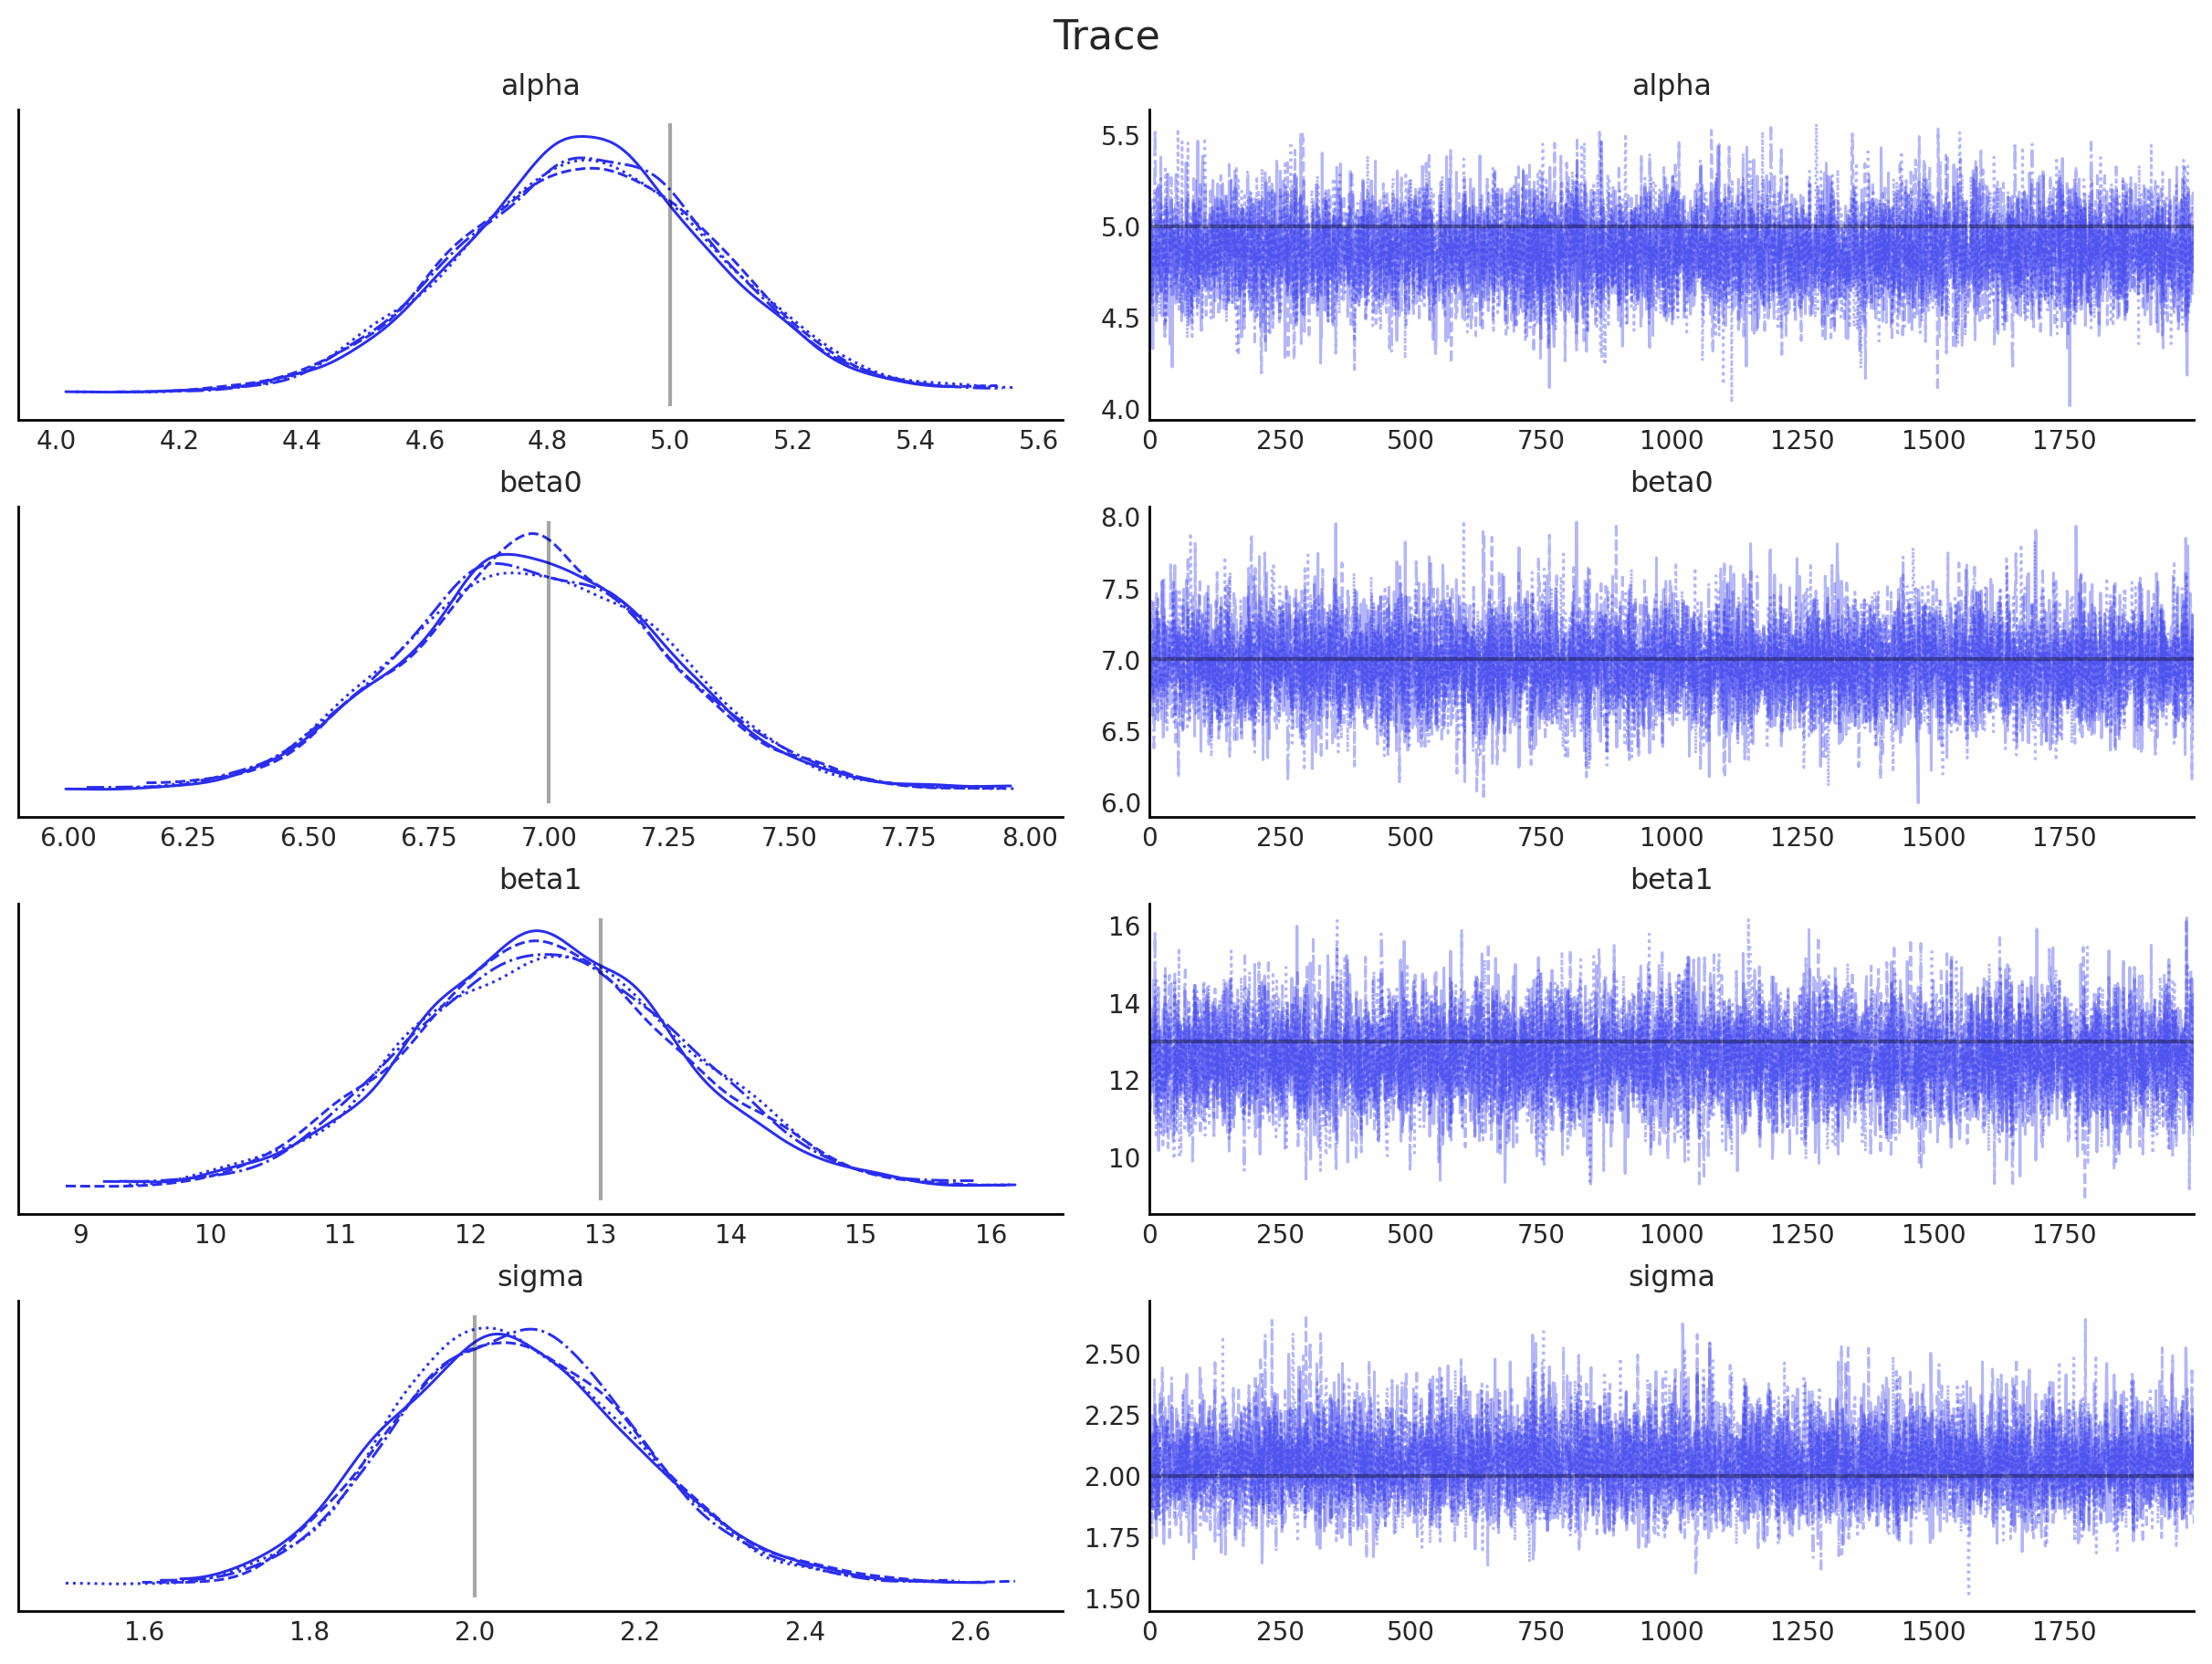

In [5]:
axes = az.plot_trace(
    data=trace,
    compact=True,
    lines=[
        ("alpha", {}, alpha_true),
        ("beta0", {}, beta0_true),
        ("beta1", {}, beta1_true),
        ("sigma", {}, sigma_true),
    ],
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In order to update our beliefs about the parameters, we use the posterior distributions, which will be used as the prior distributions for the next inference. The data used for each inference iteration has to be independent from the previous iterations, otherwise the same (possibly wrong) belief is injected over and over in the system, amplifying the errors and misleading the inference. By ensuring the data is independent, the system should converge to the true parameter values.

Because we draw samples from the posterior distribution (shown on the right in the figure above), we need to estimate their probability density (shown on the left in the figure above). [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) is a way to achieve this, and we will use this technique here. In any case, it is an empirical distribution that cannot be expressed analytically. Fortunately PyMC provides a way to use custom distributions, via {class}`~pymc.Interpolated` class.

In [6]:
def from_posterior(param, samples):
    smin, smax = samples.min().item(), samples.max().item()
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

Now we just need to generate more data and build our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. It is still possible to continue using NUTS sampling method because `Interpolated` class implements calculation of gradients that are necessary for Hamiltonian Monte Carlo samplers.

In [7]:
traces = [trace]

In [8]:
n_iterations = 10

for _ in trange(n_iterations):
    # generate more data
    X1 = rng.normal(size=size)
    X2 = rng.normal(size=size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + rng.normal(size=size, scale=sigma_true)

    with pm.Model() as model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", az.extract(trace, group="posterior", var_names=["alpha"]))
        beta0 = from_posterior("beta0", az.extract(trace, group="posterior", var_names=["beta0"]))
        beta1 = from_posterior("beta1", az.extract(trace, group="posterior", var_names=["beta1"]))
        sigma = from_posterior("sigma", az.extract(trace, group="posterior", var_names=["sigma"]))

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

        # draw 2_000 posterior samples
        trace = pm.sample(
            tune=1_500, draws=2_000, target_accept=0.9, progressbar=False, random_seed=rng
        )
        traces.append(trace)

  0%|          | 0/10 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 d

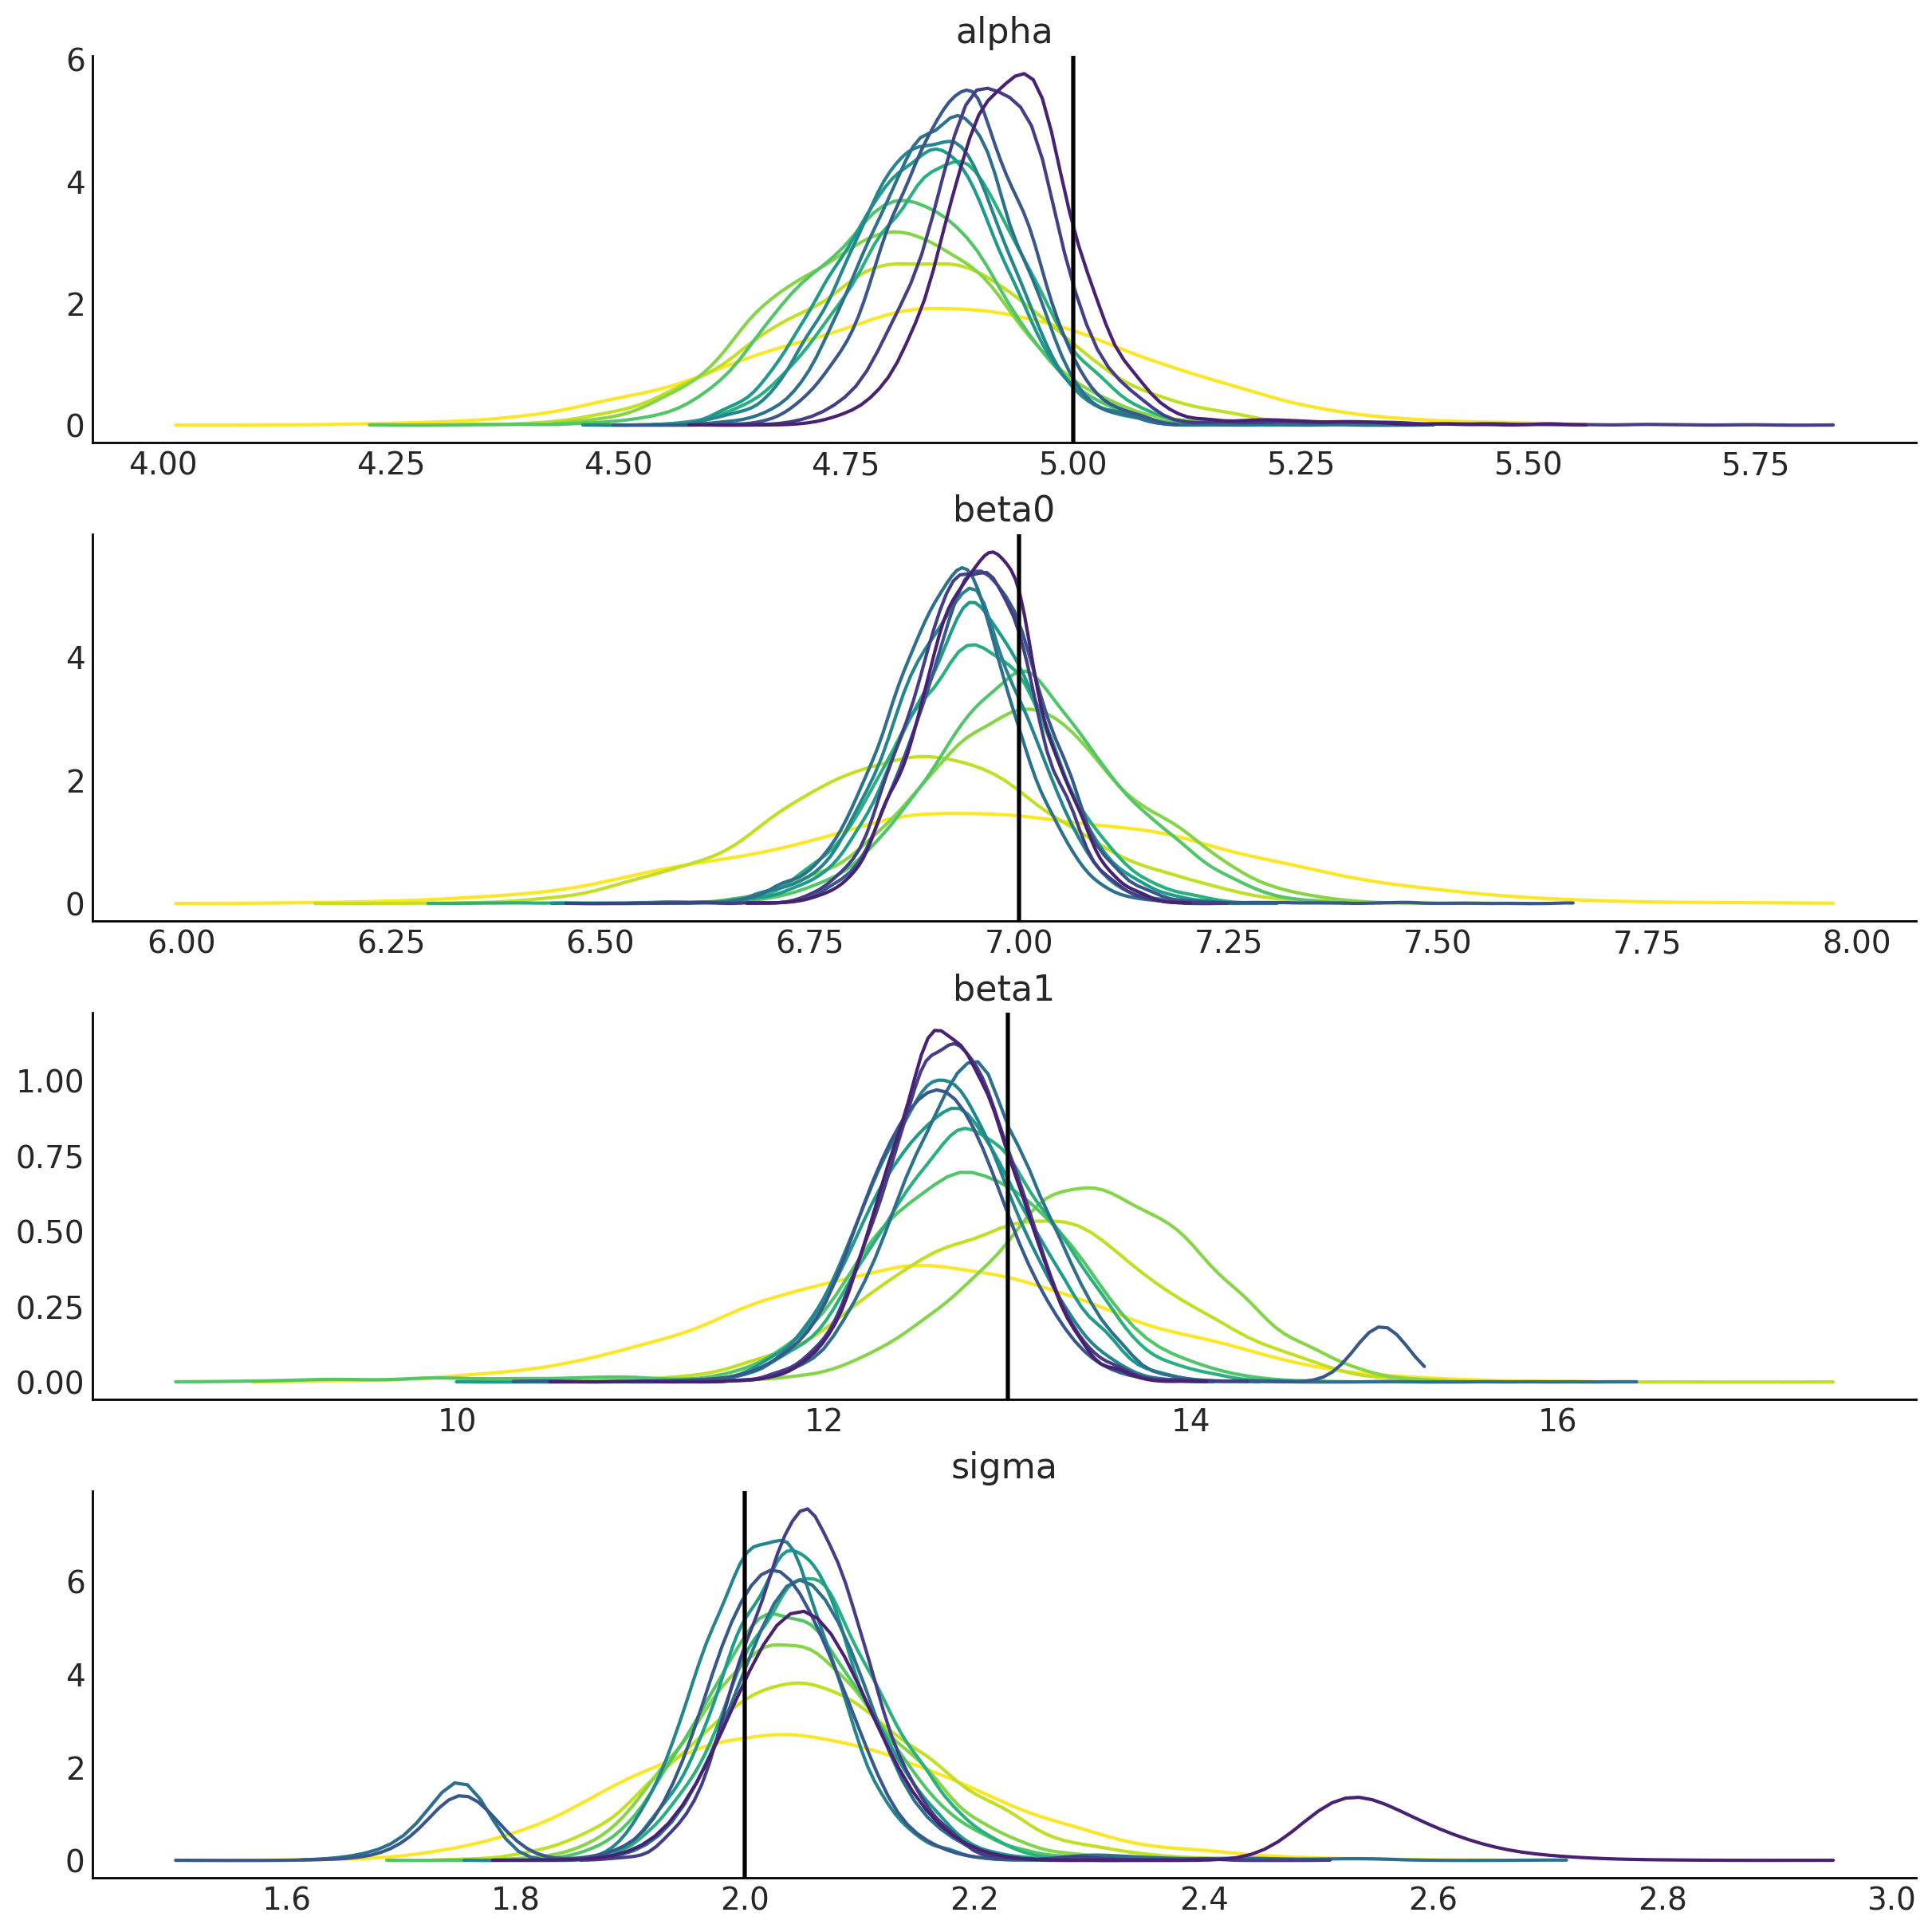

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), sharex=False, sharey=False)

cmap = mpl.cm.viridis

for i, (param, true_value) in enumerate(
    zip(["alpha", "beta0", "beta1", "sigma"], [alpha_true, beta0_true, beta1_true, sigma_true])
):
    for update_i, trace in enumerate(traces):
        samples = az.extract(trace, group="posterior", var_names=param)
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        ax[i].plot(x, y, color=cmap(1 - update_i / len(traces)))
        ax[i].axvline(true_value, c="k")
        ax[i].set(title=param)

You can re-execute the last two cells to generate more updates.

What is interesting to note is that the posterior distributions for our parameters tend to get centered on their true value (vertical lines), and the distribution gets thiner and thiner. This means that we get more confident each time, and the (false) belief we had at the beginning gets flushed away by the new data we incorporate.

``````{admonition} Not a silver bullet
:class: warning
Observe that, despite the fact that the iterations seems improving, some of them don't look so good, even sometimes it seems it regresses. In addition to reasons noted at the beginning of the notebook, there are a couple key steps in the process where randomness is involved. Thus, things should be expected to improve on average.

1. New observations are random. If in the initial iterations we get values closer to the bulk of the distribuion and then we get several values in a row from the positive tail, the iterations where we have accumulated a couple draws from the tail will probably be biased and "look worse" than previous ones.
2. MCMC is random. Even when it converges, MCMC is a random process, so different calls to `pymc.sample` will return values centered around the exact posterior but not always the same; how large a variation we should expect can be checked with {func}`arviz.mcse`. KDEs also incorporate this often negligible yet present source of uncertainty in the posterior estimates, and so will the generated Interpolated distributions.

+++

``````{admonition} An alternative approach
:class: tip
There is an alternative way in `pymc-experimental` trough the function {func}`~pymc_experimental.utils.prior.prior_from_idata` that does something similar. This function:
> Creates a prior from posterior using MvNormal approximation.
> The approximation uses MvNormal distribution. Keep in mind that this function will only work well for unimodal
> posteriors and will fail when complicated interactions happen. Moreover, if a retrieved variable is constrained, you
> should specify a transform for the variable, e.g.
> {func}`~pymc.distributions.transforms.log` for standard deviation posterior.
``````

## Authors
- Created by [David Brochart](https://github.com/davidbrochart) ([pymc#1878](https://github.com/pymc-devs/pymc/pull/1878)) on May 2017.
- Updated by [Juan Orduz](https://github.com/juanitorduz) on August 2024.

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Aug 05 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

arviz     : 0.17.1
pymc      : 5.16.1
matplotlib: 3.8.4
pytensor  : 2.23.0
numpy     : 1.26.4
scipy     : 1.12.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::